In [1]:
import numpy as np
from matplotlib import pyplot as plt
import random

def dag(X):
    return X.conj().T

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Parameters.
Ω = 1. # Rabi frequency
δ = 0.3 # Dephasing
θ = 0 # Parameter (must be zero to have a linear GKSL evolution)
γ = 1 # Bath coupling strength
β = 1 # Inverse temperature of the thermal bath
ω = 1 # Atom transition frequency
dt = 0.001
t_max = 10

# Bose-Einstein Nbar calculation (Landi et al. 2023)
Nbar = 1. / (np.exp(-β * ω) - 1.)

t_range = np.arange(0, t_max, dt)

# Loads Pauli matrices.
σx = np.array([[0,1],[1,0]], dtype="complex128")
σy = np.array([[0, -1j],[1j,0]], dtype="complex128")
σz = np.array([[1,0],[0,-1]], dtype="complex128")

# And raising and lowering operators.
σp = np.array([[0,0],[1,0]], dtype="complex128")
σm = dag(σp)

# And the identity matrix.
ide = np.array([[1,0],[0,1]], dtype="complex128")

L_Rin = Nbar * γ * σp
L_Rout = (Nbar + 1) * γ * σm

H = Ω * σx + δ * σz

In [9]:
def execute_step(ψ0, ϕ0, S0):
    # Note that this uses the SSE (not the SME) version of the stochastic evolution of the monitoring vector (see Albarelli et al. 2018).
    ρ = ψ0 @ dag(ψ0)
    
    # Computes the value of H in the perturbative dynamics.
    Hθ = (1 + θ) * H
    
    # Computes the value of the jump operators coefficients in the perturbative dynamics.
    l_Rin = (np.trace(L_Rin @ ρ @ dag(L_Rin)) - np.trace(L_Rout @ ρ @ dag(L_Rout))) / (np.trace(L_Rin @ ρ @ dag(L_Rin)) + np.trace(L_Rout @ ρ @ dag(L_Rout)))
    l_Rout = - l_Rin
    
    # Computes the jump operators.
    Lθ_Rin = np.sqrt(1 + l_Rin * θ) * L_Rin
    Lθ_Rout = np.sqrt(1 + l_Rout * θ) * L_Rout
    
    # Overall jump operator.
    J = dag(Lθ_Rin) @ Lθ_Rin + dag(Lθ_Rout) @ Lθ_Rout
    
    # Effective Hamiltonian.
    Heff = Hθ - 1j/2. * J
    
    # Kraus operators for infinitesimal time evolution.
    V_0 = ide - 1j * Heff * dt
    V_Rin = Lθ_Rin * np.sqrt(dt)
    V_Rout = Lθ_Rout * np.sqrt(dt)
    
    # Derivatives of the Kraus operators for the FI evolution.
    dV_0 = - 1j * (H - 1j/2. * (l_Rin * dag(L_Rin) @ L_Rin + l_Rout * dag(L_Rout) @ L_Rout)) * dt
    dV_Rin = l_Rin / (2 * np.sqrt(1 + l_Rin * θ)) * L_Rin * np.sqrt(dt)
    dV_Rout = l_Rout / (2 * np.sqrt(1 + l_Rout * θ)) * L_Rout * np.sqrt(dt)
    
    # Corresponding probabilities.
    p_Rin = np.real(dag(ψ0) @ dag(V_Rin) @ V_Rin @ ψ0)[0][0]
    p_Rout = np.real(dag(ψ0) @ dag(V_Rout) @ V_Rout @ ψ0)[0][0]
    
    # p_0 is defined in order to guarantee normalisation.
    p_0 = 1 - (p_Rin + p_Rout)
    
    # Chooses the Kraus operator to apply.
    t_V = np.random.choice(["V_0", "V_Rin", "V_Rout"], p=[p_0, p_Rin, p_Rout])
    
    # Lookup tables for conversion to proper operator, and to its derivative.
    dict_V = {"V_0": V_0, "V_Rin": V_Rin, "V_Rout": V_Rout}
    dict_dV = {"V_0": dV_0, "V_Rin": dV_Rin, "V_Rout": dV_Rout}
    V = dict_V[t_V]
    dV = dict_dV[t_V]
    
    # If a jump has happened, updates the accumulator of irreversible entropy produced so far.
    if t_V == "V_Rin":
        S = S0 + np.real(l_Rin)**2
    elif t_V == "V_Rout":
        S = S0 + np.real(l_Rout)**2
    else:
        S = S0 # No entropy production for coherent evolution only.
        
    
    # Updates the state.
    ψ = V @ ψ0 / np.linalg.norm(V @ ψ0)
    ϕ = (dV @ ψ0 + V @ ϕ0) / np.linalg.norm(V @ ψ0)
    
    return ψ, ϕ, S

# Single trajectory experiments

In [10]:
ψ0 = np.array([[1],[0]], dtype="complex128")
ϕ0 = np.array([[0],[0]], dtype="complex128")
S0 = 0

ψ = ψ0
ϕ = ϕ0
S = S0
v_ave_σz = []
v_stoch_fisher = []
v_stoch_entropy = []
for t in t_range:
    ψ, ϕ, S = execute_step(ψ, ϕ, S)
    ave_σz = np.real(dag(ψ) @ σz @ ψ)[0][0]
    stoch_fisher = (np.real(dag(ψ) @ ϕ + dag(ϕ) @ ψ)[0][0])**2
    v_ave_σz.append(ave_σz)
    v_stoch_fisher.append(stoch_fisher)
    v_stoch_entropy.append(S)

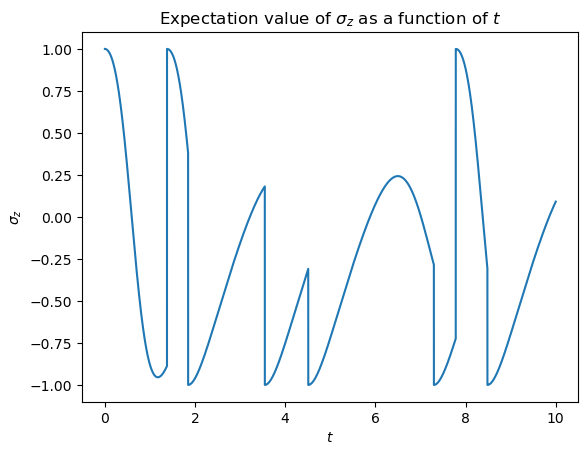

In [11]:
plt.plot(t_range, v_ave_σz)
plt.xlabel("$t$")
plt.ylabel("$\\sigma_z$")
plt.title("Expectation value of $\\sigma_z$ as a function of $t$")
plt.show()

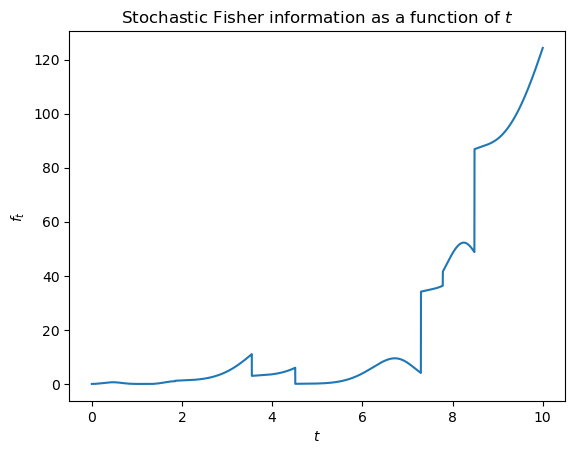

In [12]:
plt.plot(t_range, v_stoch_fisher)
plt.xlabel("$t$")
plt.ylabel("$f_t$")
plt.title("Stochastic Fisher information as a function of $t$")
plt.show()

# Multiple trajectories

In [13]:
ψ0 = np.array([[1],[0]], dtype="complex128")
ϕ0 = np.array([[0],[0]], dtype="complex128")
S0 = 0

number_trajectories = 50

v_ave_σz = []
v_stoch_fisher = []
v_stoch_entropy = []
v_ave_σz = np.zeros(len(t_range))
v_fisher = np.zeros(len(t_range))
v_entropy = np.zeros(len(t_range))
for trajectory in range(number_trajectories):
    ψ = ψ0
    ϕ = ϕ0
    S = S0
    for n_t, t in enumerate(t_range):
        ψ, ϕ, S = execute_step(ψ, ϕ, S)
        ave_σz = np.real(dag(ψ) @ σz @ ψ)[0][0]
        stoch_fisher = (np.real(dag(ψ) @ ϕ + dag(ϕ) @ ψ)[0][0])**2
        stoch_entropy = S
        v_ave_σz[n_t] += ave_σz / number_trajectories
        v_fisher[n_t] += stoch_fisher / number_trajectories
        v_entropy[n_t] += stoch_entropy / number_trajectories
    print(f"Terminated trajectory {trajectory}")

Terminated trajectory 0
Terminated trajectory 1
Terminated trajectory 2
Terminated trajectory 3
Terminated trajectory 4
Terminated trajectory 5
Terminated trajectory 6
Terminated trajectory 7
Terminated trajectory 8
Terminated trajectory 9
Terminated trajectory 10
Terminated trajectory 11
Terminated trajectory 12
Terminated trajectory 13
Terminated trajectory 14
Terminated trajectory 15
Terminated trajectory 16
Terminated trajectory 17
Terminated trajectory 18
Terminated trajectory 19
Terminated trajectory 20
Terminated trajectory 21
Terminated trajectory 22
Terminated trajectory 23
Terminated trajectory 24
Terminated trajectory 25
Terminated trajectory 26
Terminated trajectory 27
Terminated trajectory 28
Terminated trajectory 29
Terminated trajectory 30
Terminated trajectory 31
Terminated trajectory 32
Terminated trajectory 33
Terminated trajectory 34
Terminated trajectory 35
Terminated trajectory 36
Terminated trajectory 37
Terminated trajectory 38
Terminated trajectory 39
Terminated

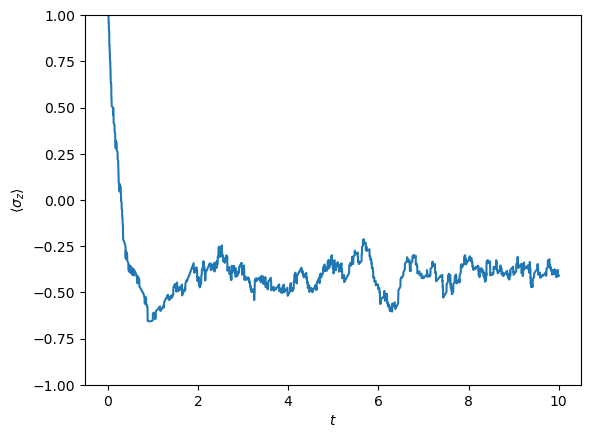

In [14]:
plt.plot(t_range, v_ave_σz)
plt.xlabel("$t$")
plt.ylabel("$\\langle\\sigma_z\\rangle$")
plt.ylim(-1,1)
plt.show()

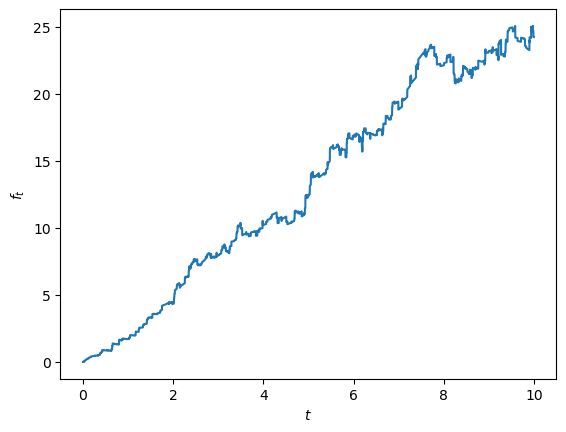

In [15]:
plt.plot(t_range, v_fisher)
plt.xlabel("$t$")
plt.ylabel("$f_t$")
plt.show()

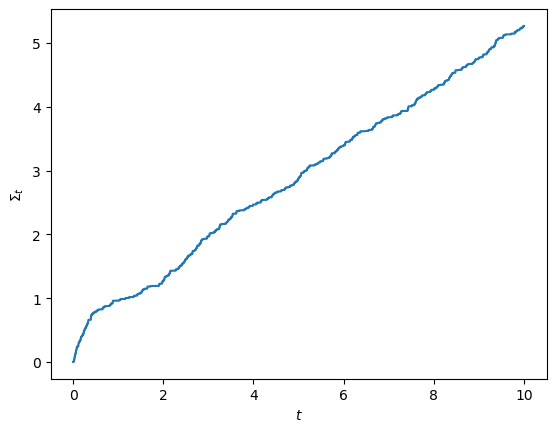

In [16]:
plt.plot(t_range, v_entropy)
plt.xlabel("$t$")
plt.ylabel("$\\Sigma_t$")
plt.show()

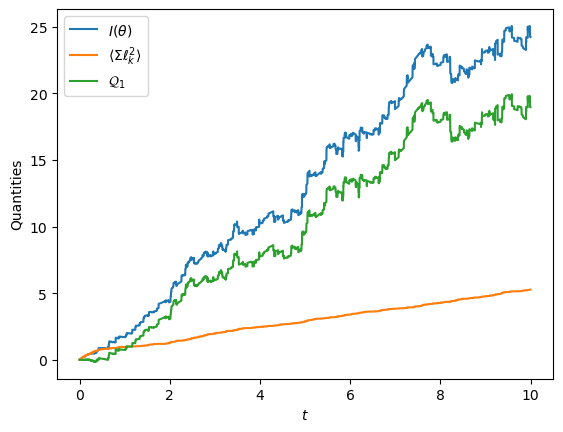

In [23]:
v_q1 = v_fisher - v_entropy

plt.plot(t_range, v_fisher, label="$I(\\theta)$")
plt.plot(t_range, v_entropy, label="$\\langle\\Sigma \ell_k^2\\rangle$")
plt.plot(t_range, v_q1, label="$\\mathcal{Q}_1$")
plt.legend()
plt.xlabel("$t$")
plt.ylabel("Quantities")
plt.show()